# Hybrid_Recursive_feature_elimination

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score, r2_score

In [2]:
# Read the csv file
df = pd.read_csv("data/diagnosis.csv")
df.head()

,ID number,Diagnosis,Radius mean,Texture mean,Perimeter mean,Area mean,Smoothness mean,Compactness mean,Concavity mean,Concave Points mean,...,Radius worst,Texture worst,Perimeter worst,Area worst,Smoothness worst,Compactness worst,Concavity worst,Concave Points worst,Symmetry worst,Fractal Dimension worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [3]:
df.columns

Index(['ID number', 'Diagnosis', 'Radius mean', 'Texture mean',
       'Perimeter mean', 'Area mean', 'Smoothness mean', 'Compactness mean',
       'Concavity mean', 'Concave Points mean', 'Symmetry mean',
       'Fractal Dimension mean', 'Radius SE', 'Texture SE', 'Perimeter SE',
       'Area SE', 'Smoothness SE', 'Compactness SE', 'Concavity SE',
       'Concave Points SE', 'Symmetry SE', 'Fractal Dimension SE',
       'Radius worst', 'Texture worst', 'Perimeter worst', 'Area worst',
       'Smoothness worst', 'Compactness worst', 'Concavity worst',
       'Concave Points worst', 'Symmetry worst', 'Fractal Dimension worst'],
      dtype='object')

In [4]:
# Prepare target data
target = df["Diagnosis"]
target_names = ["malignant", "benigh"]
target = target.map({'M': 1, 'B': 0})
target.head()

0    1
1    1
2    1
3    1
4    1
Name: Diagnosis, dtype: int64

In [5]:
# Prepare feature data
data = df.drop(["ID number", "Diagnosis"], axis=1)
feature_names = data.columns
data.head()

,Radius mean,Texture mean,Perimeter mean,Area mean,Smoothness mean,Compactness mean,Concavity mean,Concave Points mean,Symmetry mean,Fractal Dimension mean,...,Radius worst,Texture worst,Perimeter worst,Area worst,Smoothness worst,Compactness worst,Concavity worst,Concave Points worst,Symmetry worst,Fractal Dimension worst
0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [6]:
# Use train_test_split to create training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [7]:
X_train.shape, X_test.shape

((426, 30), (142, 30))

In [8]:
# the first step of this procedure  consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# set the seed for reproducibility
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model using all the features
model_all_features = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

model_all_features.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_all_features.predict_proba(X_test)[:, 1]
auc_score_all = roc_auc_score(y_test, y_pred_test)
print('Test all features xgb ROC AUC=%f' % (auc_score_all))

Test all features xgb ROC AUC=0.977638


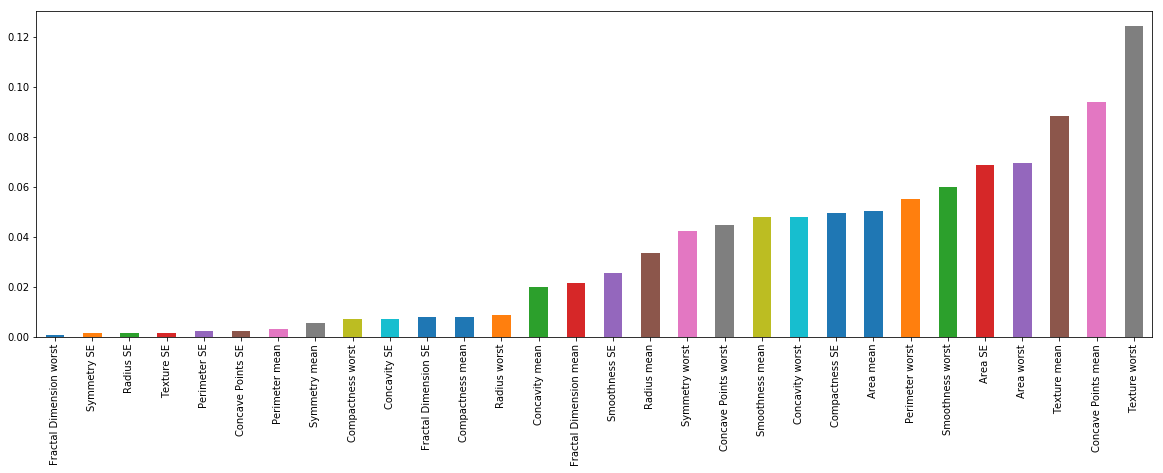

In [9]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))

In [10]:
# view the list of ordered features
features = list(features.index)
features

['Fractal Dimension worst',
 'Symmetry SE',
 'Radius SE',
 'Texture SE',
 'Perimeter SE',
 'Concave Points SE',
 'Perimeter mean',
 'Symmetry mean',
 'Compactness worst',
 'Concavity SE',
 'Fractal Dimension SE',
 'Compactness mean',
 'Radius worst',
 'Concavity mean',
 'Fractal Dimension mean',
 'Smoothness SE',
 'Radius mean',
 'Symmetry worst',
 'Concave Points worst',
 'Smoothness mean',
 'Concavity worst',
 'Compactness SE',
 'Area mean',
 'Perimeter worst',
 'Smoothness worst',
 'Area SE',
 'Area worst',
 'Texture mean',
 'Concave Points mean',
 'Texture worst']

In [11]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an xgboost at each round.

# once we build the model, we calculate the new roc-auc
# if the new roc-auc is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know how far ahead the loop is going
count = 1

# now we loop over all the features, in order of importance:
# remember that features is the list of ordered features
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = xgb.XGBClassifier(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    auc_score_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((auc_score_int)))

    # print the original roc-auc with all the features
    print('All features Test ROC AUC={}'.format((auc_score_all)))

    # determine the drop in the roc-auc
    diff_auc = auc_score_all - auc_score_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_auc >= tol:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_auc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        auc_score_all = auc_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

doing recursive feature elimination

testing feature:  Fractal Dimension worst  which is feature  1  out of  30
New Test ROC AUC=0.9774294670846396
All features Test ROC AUC=0.9776384535005225
Drop in ROC AUC=0.00020898641588285027
remove:  Fractal Dimension worst

testing feature:  Symmetry SE  which is feature  2  out of  30
New Test ROC AUC=0.9782654127481714
All features Test ROC AUC=0.9774294670846396
Drop in ROC AUC=-0.0008359456635317342
remove:  Symmetry SE

testing feature:  Radius SE  which is feature  3  out of  30
New Test ROC AUC=0.9780564263322884
All features Test ROC AUC=0.9782654127481714
Drop in ROC AUC=0.0002089864158829613
remove:  Radius SE

testing feature:  Texture SE  which is feature  4  out of  30
New Test ROC AUC=0.9786833855799374
All features Test ROC AUC=0.9780564263322884
Drop in ROC AUC=-0.0006269592476489949
remove:  Texture SE

testing feature:  Perimeter SE  which is feature  5  out of  30
New Test ROC AUC=0.9788923719958202
All features Test ROC AUC=

In [12]:
# capture the 56 selected features
seed_val = 1000000000
np.random.seed(seed_val)

# build initial model
final_xgb = xgb.XGBClassifier(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05)

# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = final_xgb.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
auc_score_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (auc_score_final))
print('Test all features ROC AUC=%f' % (auc_score_all))

Test selected features ROC AUC=0.991432
Test all features ROC AUC=0.991432


In [13]:
features_to_keep

['Concave Points SE',
 'Perimeter mean',
 'Symmetry worst',
 'Concave Points worst',
 'Compactness SE',
 'Area SE',
 'Area worst',
 'Concave Points mean']

In [14]:
features_to_keep.append('Diagnosis')
features_to_keep

['Concave Points SE',
 'Perimeter mean',
 'Symmetry worst',
 'Concave Points worst',
 'Compactness SE',
 'Area SE',
 'Area worst',
 'Concave Points mean',
 'Diagnosis']

In [17]:
selected_diagnosis_1 = df[features_to_keep]
selected_diagnosis_1.head()

,Concave Points SE,Perimeter mean,Symmetry worst,Concave Points worst,Compactness SE,Area SE,Area worst,Concave Points mean,Diagnosis
0,0.01340,132.90,0.2750,0.1860,0.01308,74.08,1956.0,0.07017,M
1,0.02058,130.00,0.3613,0.2430,0.04006,94.03,1709.0,0.12790,M
2,0.01867,77.58,0.6638,0.2575,0.07458,27.23,567.7,0.10520,M
3,0.01885,135.10,0.2364,0.1625,0.02461,94.44,1575.0,0.10430,M
4,0.01137,82.57,0.3985,0.1741,0.03345,27.19,741.6,0.08089,M


In [19]:
selected_diagnosis_1.to_csv("selected_diagnosis_1.csv", index=False)